In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [54]:
train = pd.read_csv("../data/train.csv").set_index('id')
test = pd.read_csv("../data/test.csv").set_index('id')

In [55]:
print(f"Total columns in the train dataset is: {len(train.columns)}")
print(train.columns.values)

Total columns in the train dataset is: 34
['X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas' 'Pastry'
 'Z_Scratch' 'K_Scatch' 'Stains' 'Dirtiness' 'Bumps' 'Other_Faults']


In [56]:
target_classes = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
targets = train[target_classes]
train = train.drop(target_classes, axis='columns')

In [57]:
targets.sum(axis=0)

Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64

In [58]:
# let us the see the sum along the rows

print(f"Unique sum values long the row are: {np.unique(targets.sum(axis=1))}")
print(f"Count of occurrences of the unique values are:\n{targets.sum(axis=1).value_counts()}")
# we can conclude that there are 3 different types, by logic there should only have been 1 unique value i.e. 1

Unique sum values long the row are: [0 1 2]
Count of occurrences of the unique values are:
1    18380
0      818
2       21
dtype: int64


Different tyes of faults in the steel are:

- **Pastry:** Surface defect resembling a pastry, typically caused by improper cooling during production.
- **Z_Scratch:** Narrow, linear scratch formation on the surface of steel, often caused by mishandling or abrasion.
- **K_Scratch:** Similar to Z_Scratch, but with a different orientation, indicating distinct causes or manufacturing processes.
- **Stains:** Discoloration or blemishes on the steel surface, often caused by chemical reactions or improper storage.
- **Dirtiness:** Presence of foreign particles or contaminants on the steel surface, compromising its integrity.
- **Bumps:** Raised irregularities on the steel surface, usually resulting from uneven rolling or processing.
- **Other_Faults:** Miscellaneous defects not categorized under specific types, indicating a range of possible issues in steel production.

In [59]:
target = targets @ (np.arange(targets.shape[1])+1)
target[targets.sum(axis=1)==2] = 3

In [60]:
target.value_counts() / len(target)
# target.value_counts()

7    0.340288
6    0.247724
3    0.178573
1    0.076227
2    0.059837
0    0.042562
4    0.029554
5    0.025235
dtype: float64

In [61]:
target_classes_tmp = ['Zero_defect', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

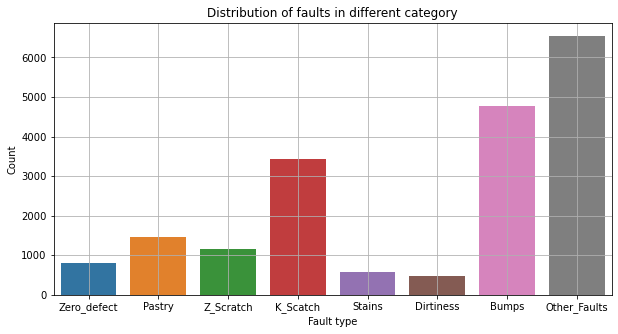

In [62]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=target)
ax.set_xticklabels(target_classes_tmp)
ax.grid()
ax.set_title("Distribution of faults in different category")
ax.set_xlabel("Fault type")
ax.set_ylabel("Count")
plt.show()

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

In [64]:
X = pd.concat([train, test], axis=0)
y = [0] * len(train) + [1]*len(test)
model = RandomForestClassifier(random_state=37)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')
score = roc_auc_score(y, cv_preds[:,1])
print(f"roc-auc score: {score:0.4f}")

roc-auc score: 0.5010


In [66]:
def calculate_coordinate_range_features(data):
    data['X_range'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_range'] = data['Y_Maximum'] - data['Y_Minimum']
    return data

train = calculate_coordinate_range_features(train)
test = calculate_coordinate_range_features(test)

In [67]:
def calculate_size_ratio_features(data):
    data['Area_perimeter_ratio'] = data['Pixels_Areas']/(data['X_Perimeter'] + data['Y_Perimeter'])
    return data

train = calculate_size_ratio_features(train)
test = calculate_size_ratio_features(test)

In [68]:
def calculate_luminosity_range_features(data):
    data['Luminosity_range'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']
    return data

train = calculate_luminosity_range_features(train)
test = calculate_luminosity_range_features(test)

In [71]:
pd.Series(target, name='target').to_csv("target.csv")

In [72]:
from sklearn.preprocessing import MinMaxScaler

train = train.astype(np.float64)
test = test.astype(np.float64)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train)
train[:] = min_max_scaler.transform(train)
test[:] = min_max_scaler.transform(test)

In [93]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=37)
cv_splits = cv.split(train, target)

In [101]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier

In [132]:
cv_splits = cv.split(train, target)
roc_auc_scores = list()
cv_oof = pd.DataFrame(np.zeros((len(target), len(target_classes_tmp))), columns=target_classes_tmp)

In [133]:
from tqdm import tqdm
for train_idx, val_idx in tqdm(cv_splits):
    xgb = XGBClassifier(booster='gbtree', device='cuda', tree_method='hist', objective='multi:softmax',
                        num_class=len(set(target)), n_estimators=300, max_depth=6, verbostiy=0)
    
    X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]
    
    xgb.fit(X_train_fold, y_train_fold)
    y_val_prob = xgb.predict_proba(X_val_fold)
    print(y_val_prob.shape)
    print(targets.shape)
    roc_auc = roc_auc_score(targets.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr')
    cv_oof.iloc[val_idx, :] = y_val_prob
    roc_auc_scores.append(roc_auc)
    
roc_auc_mean = np.mean(roc_auc_scores)
roc_auc_std = np.std(roc_auc_scores)
roc_auc_max = np.max(roc_auc_scores)
roc_auc_min = np.min(roc_auc_scores)

print(f"Cross validated ROC-AUC score: {roc_auc_mean:.3f} +/- {roc_auc_std:.3f}")
print(f"Max ROC-AUC score: {roc_auc_max:.3f}")
print(f"Min ROC-AUC score: {roc_auc_min:.3f}")

1it [00:05,  5.91s/it]

(3844, 8)
(19219, 7)


2it [00:12,  6.32s/it]

(3844, 8)
(19219, 7)


3it [00:19,  6.53s/it]

(3844, 8)
(19219, 7)


4it [00:26,  6.85s/it]

(3844, 8)
(19219, 7)


5it [00:33,  6.74s/it]

(3843, 8)
(19219, 7)
Cross validated ROC-AUC score: 0.874 +/- 0.003
Max ROC-AUC score: 0.878
Min ROC-AUC score: 0.869


In [122]:
from sklearn.metrics import classification_report
print(classification_report(target, np.argmax(cv_oof.values, axis=1), target_names=target_classes_tmp))

              precision    recall  f1-score   support

 Zero_defect       0.07      0.01      0.01       818
      Pastry       0.37      0.21      0.27      1465
   Z_Scratch       0.61      0.58      0.60      1150
    K_Scatch       0.88      0.90      0.89      3432
      Stains       0.70      0.79      0.74       568
   Dirtiness       0.40      0.14      0.21       485
       Bumps       0.49      0.50      0.49      4761
Other_Faults       0.47      0.58      0.52      6540

    accuracy                           0.56     19219
   macro avg       0.50      0.46      0.47     19219
weighted avg       0.54      0.56      0.54     19219



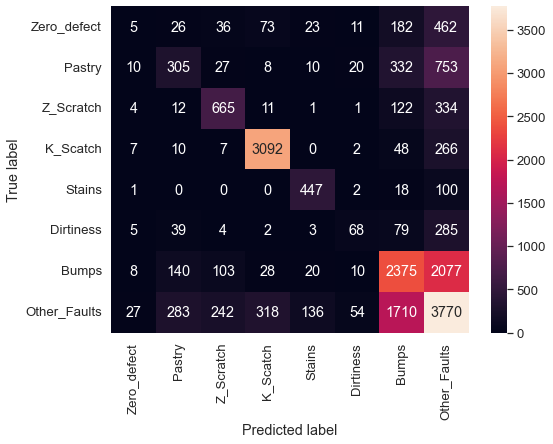

In [124]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(target, np.argmax(cv_oof.values, axis=1))
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_classes_tmp, yticklabels=target_classes_tmp)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [125]:
import optuna
from optuna.samplers import TPESampler

run_optimization = False

In [142]:
def objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    }
    
    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params['device'] = 'cpu'
    params['verbosity'] = 0
    params['tree_method'] = 'hist'
    
    cv_splits = cv.split(train, target)
    cv_scores = list()
    
    for train_idx, val_idx in cv_splits:
        xgb = XGBClassifier(**params)

        X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
        y_train_fold, y_val_fold = target[train_idx], target[val_idx]

        xgb.fit(X_train_fold, y_train_fold)
        y_val_prob = xgb.predict_proba(X_val_fold)
        cv_scores.append(roc_auc_score(targets.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr'))
        
    cv_evaluation = np.mean(cv_scores)
    return cv_evaluation

study = optuna.create_study(direction='maximize', load_if_exists=True, study_name='first_study')
study.optimize(objective, n_trials=20)

best_cls_params = study.best_params
best_value = study.best_value

[I 2024-03-15 18:16:12,496] A new study created in memory with name: first_study
[I 2024-03-15 18:16:31,289] Trial 0 finished with value: 0.8660200748362958 and parameters: {'grow_policy': 'depthwise', 'n_estimators': 463, 'learning_rate': 0.70008896564255, 'gamma': 0.04087269102858979, 'subsample': 0.9732698943456526, 'colsample_bytree': 0.4948771046692016, 'max_depth': 5, 'min_child_weight': 2, 'reg_lambda': 3.2328663979844373e-06, 'reg_alpha': 1.7622383075148186e-06}. Best is trial 0 with value: 0.8660200748362958.
[I 2024-03-15 18:17:20,460] Trial 1 finished with value: 0.8886630094321568 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 814, 'learning_rate': 0.010203899353003507, 'gamma': 0.4310675068202116, 'subsample': 0.7344681771744559, 'colsample_bytree': 0.40218923630395664, 'max_depth': 4, 'min_child_weight': 7, 'reg_lambda': 1.0347843846943514e-09, 'reg_alpha': 3.7850834751973452}. Best is trial 1 with value: 0.8886630094321568.
[I 2024-03-15 18:17:47,514] Trial

[I 2024-03-15 18:39:25,770] Trial 19 finished with value: 0.8761491553906733 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 955, 'learning_rate': 0.17048743885366394, 'gamma': 0.4109528062695604, 'subsample': 0.6488403116469338, 'colsample_bytree': 0.4792214352345531, 'max_depth': 10, 'min_child_weight': 5, 'reg_lambda': 0.004566829431597013, 'reg_alpha': 0.07224505664372034}. Best is trial 13 with value: 0.8898961785765686.


In [143]:
best_cls_params

{'grow_policy': 'lossguide',
 'n_estimators': 359,
 'learning_rate': 0.021831265569244144,
 'gamma': 0.4078371165756942,
 'subsample': 0.6347737565718329,
 'colsample_bytree': 0.3015363399335394,
 'max_depth': 5,
 'min_child_weight': 6,
 'reg_lambda': 0.040505779969286,
 'reg_alpha': 0.0017170850766717893}

In [144]:
best_value

0.8898961785765686

In [146]:
xgb = XGBClassifier(**best_cls_params)
xgb.fit(train, target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3015363399335394, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4078371165756942,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.021831265569244144,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=359, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [154]:
def compute_oof(X, y, model, model_params, cv_strategy):
    
    cv_splits = cv_strategy.split(X, y=y)
    cv_oof = pd.DataFrame(np.zeros((len(y), len(target_classes_tmp))), columns=target_classes_tmp)
    
    for train_idx, val_idx in cv_splits:

        instantiated_model = model(**model_params)

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        instantiated_model.fit(X_train_fold, y_train_fold)

        y_val_prob = instantiated_model.predict_proba(X_val_fold)
        print(y_val_prob.shape)
        cv_oof.iloc[val_idx, :] = y_val_prob
    
    return cv_oof

In [155]:
xgb_preds = xgb.predict_proba(test)
xgb_oof = compute_oof(train, target, XGBClassifier, best_cls_params, cv)

(3844, 8)
(3844, 8)
(3844, 8)
(3844, 8)
(3843, 8)


In [162]:
xgb_preds_tmp = xgb_preds

In [164]:
xgb_preds_tmp = xgb_preds_tmp[:, 1:]
xgb_preds_tmp.shape

(12814, 7)

In [165]:
submission = pd.read_csv("../data/sample_submission.csv")
submission.iloc[:, 1:] = xgb_preds_tmp

In [168]:
submission.to_csv("../data/submission_xgboost_tutorial.csv", index=False)